If you're reading this as a pdf, my appologies for some of the code being cut off. I made it originally as an ipython notebook, and all of the options to turn it into a pdf seem to result in some amount of loss.

In [8]:
# imports; may not end up using all of these
import pandas as pd, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, \
    scipy as sp, scipy.stats as spstat, sklearn as sk, datetime as dt, \
    statsmodels.api as sm, statsmodels.formula.api as smf
from __future__ import division
from datetime import datetime, time
from pandas.tseries.offsets import DateOffset
from orthogonal_poly import *   # replicates the poly command in R
%matplotlib inline

###Do some basic data cleaning
#####I start with reading in and merging the two data sets

In [16]:
# read in the two data sets and merge them into one, matching the id_user in assign to id_guest in contacts
assign = pd.read_csv("takehome_assignments.csv",header=0)
contacts = pd.read_csv("takehome_contacts.csv",header=0)

# I normally avoid concatenating two tables just by row number (its better to be careful and merge by unique id)
# However, that is unavoidable in this case, since id_guest doesn't uniquely define the rows of assign, 
# and the row numbers appear to match
data = pd.concat([assign,contacts],1)

# Check to make sure that I got the matching I wanted
print "id_user and id_guest are mismatched %d times" % (sum(data.id_guest!=data.id_user))

id_user and id_guest are mismatched 0 times


Deal with same guest & listing combo appearing multiple times

In [17]:
# Drop the redundant id_user column
data.drop('id_user',axis=1,inplace=True)

# Index the data set by the three ids, and see if there are any dupplicates
# One would presume that if a guest contacts a host twice, that might have some effect on the response times
data.set_index(keys=["id_guest","id_host","id_listing"],inplace=True)
dups = data.index.get_duplicates()
data.loc[dups]

ab  \
id_guest                             id_host                              id_listing                                        
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf    control   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf  treatment   

                                                                                                               ts_interaction_first  \
id_guest                             id_host                              id_listing                                                  
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-07 20:08:25   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-03 10:36:47   

                                                                                                                    ts_reply_at_first  \
id_guest                             id_host                              id_listing                                                    
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-07 20:06:46.0   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-03 14:53:52.0   

                                                                                                                 ts_accepted_at_first  \
id_guest                             id_host                              id_listing                                                    
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-07 20:06:46.0   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-03 22:25:24.0   

                                                                                                                        ts_booking_at  \
id_guest                             id_host                              id_listing                                                    
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-07 20:06:46.0   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf  2013-01-04 07:13:06.0   

                                                                                                               dim_contact_channel  \
id_guest                             id_host                              id_listing                                                 
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf             book_it   
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf          contact_me   

                                                                                                                m_first_message_length  
id_guest                             id_host                              id_listing                                                    
358f8e36-f99a-42d8-82e6-0b0577910900 cb0b0e8b-061c-4bf6-9e5a-db806ffaa3d3 e723dcab-3a75-4f72-97b9-daf264e604cf                       0  
                                                                          e723dcab-3a75-4f72-97b9-daf264e604cf                     239

There is only one case of a duplicated request, so I'm just going to drop the duplicate and the original. One might just keep the contact_me observation which occured first and drop the book_it observation which occured second, but it doesn't make much difference either way

In [18]:
# drop it like it's hot
data.drop(dups,axis=0,inplace=True)

#####Convert the time stamps from strings to a datetime value

Now, I'm going to clean up these dates. I want the time of the first contact, and then the time lags from that to the other time variables.

In [19]:
# first, replace each string variable with a date time variable
timevars = ["ts_interaction_first","ts_reply_at_first","ts_accepted_at_first","ts_booking_at"]
for tv in timevars:
    data[tv] = pd.to_datetime(data[tv])

# Calculate lags from first interaction:
for tv in timevars[1:]:
    data[tv + '_lag'] = data[tv] - data.ts_interaction_first    
    
# Sense checks. Do the time variables follow the proper order?
for i in range(len(timevars)):
    for j in range(i+1,len(timevars)):
        tv1, tv2 = timevars[i],timevars[j]
        print "%s preceeded %s %d times" % (tv1,tv2,sum(np.logical_and(pd.notnull(data[tv2]),data[tv1]>data[tv2])))

ts_interaction_first preceeded ts_reply_at_first 154 times
ts_interaction_first preceeded ts_accepted_at_first 109 times
ts_interaction_first preceeded ts_booking_at 87 times
ts_reply_at_first preceeded ts_accepted_at_first 0 times
ts_reply_at_first preceeded ts_booking_at 0 times
ts_accepted_at_first preceeded ts_booking_at 0 times


It seems that sometimes there are issues with the first interaction preceeding the follow ups (which should be impossible)


In [20]:
# Lets take a look at a few examples
tv1,tv2 = 'ts_interaction_first', 'ts_reply_at_first'
data.loc[np.logical_and(pd.notnull(data[tv2]),data[tv1]>data[tv2])].head()

,,,ab,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,dim_contact_channel,m_first_message_length,ts_reply_at_first_lag,ts_accepted_at_first_lag,ts_booking_at_lag
id_guest,id_host,id_listing,,,,,,,,,,
30abce0e-e105-41b0-b31a-0673efa0cd26,a8b671c7-4bdf-4896-b42f-2ba1b1a93adf,6e59bc7e-8084-4ff4-a1b2-21399a6b8829,treatment,2013-02-11 09:51:06,2013-02-11 09:49:27,2013-02-11 09:49:27,2013-02-11 09:49:27,instant_booked,391,-1 days +23:58:21,-1 days +23:58:21,-1 days +23:58:21
0de89a34-2978-4bbf-b60a-f6607affa804,f50d600e-b995-4313-aa7b-a5ac605bf5e0,5051a4f0-d301-48f3-81fc-093c8550570b,treatment,2013-03-08 05:36:44,2013-03-08 05:36:33,2013-03-08 05:36:33,2013-03-08 05:36:33,book_it,277,-1 days +23:59:49,-1 days +23:59:49,-1 days +23:59:49
14f79f2c-cd59-4f28-bb92-0c9b0100479d,f5539bb0-8edf-4135-b753-0daaa650d6dc,c9bba49e-525d-4762-9daa-a687d4fd7cc3,control,2013-03-10 21:23:13,2013-03-10 21:22:57,2013-03-11 02:31:25,2013-03-11 02:31:25,contact_me,193,-1 days +23:59:44,05:08:12,05:08:12
ef1a48d7-e2f0-4820-b54c-4e8b0860ccc6,a73083f8-89c8-4d3a-b079-f8b00f57c71e,4348c9ec-6f7c-4301-a159-a771b4c5cbbc,treatment,2013-03-15 17:17:17,2013-03-15 17:16:17,NaT,NaT,contact_me,274,-1 days +23:59:00,NaT,NaT
9d155939-c4c1-4fad-9328-ddc853034ecb,dd6affae-f76d-40dd-a31f-aaee70334e8d,b94f0316-2f10-4f62-b2e7-58e095f612d8,control,2013-03-19 16:24:31,2013-03-19 16:22:51,NaT,NaT,contact_me,0,-1 days +23:58:20,NaT,NaT


These negative lags seem to generally be only a matter of a minute or two, and may just be a small bug, especially for 'instant_booked'

In [21]:
# How many negative lags are more than two minutes?
print 'Negative lags exceeding 2 minutes happened %d times' % sum(data['ts_reply_at_first_lag'] < np.timedelta64(-2, 'm'))

# Looking at the not 'instant_booked', which are of more interest anyway, how often do we see a small negative lags
# compared to a small positive lag?
not_instant = data['dim_contact_channel']!='instant_booked'
print '\nExcluding instant booked:'
for j in range(1,len(timevars)):
    lag = data[timevars[j]+'_lag']
    neg_lags = sum(np.logical_and(not_instant,lag<0))
    pos_lags = sum(np.logical_and(not_instant,np.logical_and(lag>=np.timedelta64(0, 'm'),lag<np.timedelta64(2, 'm'))))
    print '%s had %d lags less than 0 and %d between 0 and 2' % (timevars[j],neg_lags,pos_lags)
    

Negative lags exceeding 2 minutes happened 0 times

Excluding instant booked:
ts_reply_at_first had 112 lags less than 0 and 254 between 0 and 2
ts_accepted_at_first had 67 lags less than 0 and 97 between 0 and 2
ts_booking_at had 45 lags less than 0 and 48 between 0 and 2


My guess is that there is some kind of bug in the determination of first interaction time, but it seems to be only fudging the numbers by a minute or two. Since it looks like there are a lot of very quick response times (maybe some sort of auto reply by the host), I'm going with that the negative lags really represent small positive lags which have a small error on them. Thus, I'm leaving them in the data set.

##### Make sure the treatment group really did write messages longer than 140 characters

In [22]:
# encode missing lengths as 0
data.m_first_message_length.loc[pd.isnull(data.m_first_message_length)]=0

less_than_req = np.logical_and(data.ab=='treatment',data.m_first_message_length<140)
print "there were %d in the treatment group who didn't write 140 charchters" % sum(less_than_req)

there were 730 in the treatment group who didn't write 140 charchters


Well, we can't really have that. I'm going to exclude those who got the treatment but didn't write 140 charachters. 

In [23]:
data = data[np.logical_not(less_than_req)]

#####Create some additional variables

In [24]:
# Did the host ever reply?
data['replied'] = pd.notnull(data['ts_reply_at_first'])
# Did the host accept?
data['accepted'] = pd.notnull(data['ts_accepted_at_first'])
# Did the guest book?
data['booked'] = pd.notnull(data['ts_booking_at'])
# What hour of the day did the guest initiate contact?
data['interaction_hour'] = data.ts_interaction_first.dt.hour
# Was contact on a weekend?
data['weekend_interaction'] = data.ts_interaction_first.dt.dayofweek<5
# What month of 2013 did the contact occur in?
data['month_interaction'] = data.ts_interaction_first.dt.month.astype('category')
# Was the message longer than 140 charchters?
data['long_message'] = data.m_first_message_length>=140

##### Subset the data to exclude instant booked
instant_booked books without the host seeing the message, so there is no point in looking into them for this experiment

In [25]:
full_data, data = data.copy(), data.loc[not_instant].copy() # this is a tad lazy
n = data.shape[0]
print 'We are left with %d observations' % n

We are left with 9233 observations


### Look at some univariate statistics
##### First, compare the treatment to control groups. Did the randominization seem to work correctly?

In [26]:
pd.crosstab(data['ab'],data['dim_contact_channel']).apply(lambda r: r/r.sum(), axis=1)

dim_contact_channel,book_it,contact_me
ab,,
control,0.182785,0.817215
treatment,0.174394,0.825606


In [27]:
pd.crosstab(data['ab'],data['interaction_hour']).apply(lambda r: r/r.sum(), axis=1)

interaction_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ab,,,,,,,,,,,,,,,,,,,,,
control,0.048154,0.049157,0.043539,0.042737,0.043740,0.042937,0.033507,0.027488,0.019462,0.021268,...,0.033507,0.044743,0.050361,0.058989,0.062801,0.060193,0.060995,0.060393,0.054374,0.050161
treatment,0.045893,0.043069,0.047070,0.044481,0.041657,0.039068,0.032243,0.028242,0.023535,0.022123,...,0.037185,0.045893,0.048482,0.054130,0.060720,0.060014,0.061662,0.055072,0.063074,0.051777


In [28]:
pd.crosstab(data['ab'],data['weekend_interaction']).apply(lambda r: r/r.sum(), axis=1)

weekend_interaction,False,True
ab,,
control,0.238965,0.761035
treatment,0.239821,0.760179


In [29]:
pd.crosstab(data['ab'],data['month_interaction']).apply(lambda r: r/r.sum(), axis=1)

month_interaction,1,2,3,4,5,6,7,8,9,10,11,12
ab,,,,,,,,,,,,
control,0.062400,0.062801,0.084872,0.105738,0.107143,0.097311,0.108146,0.104334,0.083066,0.070225,0.057584,0.056380
treatment,0.058602,0.068487,0.094610,0.100024,0.114380,0.093434,0.104495,0.098141,0.089668,0.064015,0.055778,0.058367


These all pass the sniff test; both groups seemed to be contacting hosts at similar times. If there are meaningful differences in the group up to the point they send the request, it has to be burried in the joint distribution.

##### See initial differences in booking and respnse time between the groups

In [30]:
pd.crosstab(data['ab'],data['replied']).apply(lambda r: r/r.sum(), axis=1)

replied,False,True
ab,,
control,0.147071,0.852929
treatment,0.138856,0.861144


In [31]:
pd.crosstab(data['ab'],data['booked']).apply(lambda r: r/r.sum(), axis=1)

booked,False,True
ab,,
control,0.787721,0.212279
treatment,0.789833,0.210167


The control group got responses a little more often, but this just looks like noise to me. Maybe the response or acceptances were quicker though. Let's take a look at the cumulative response and acceptance rate over time.

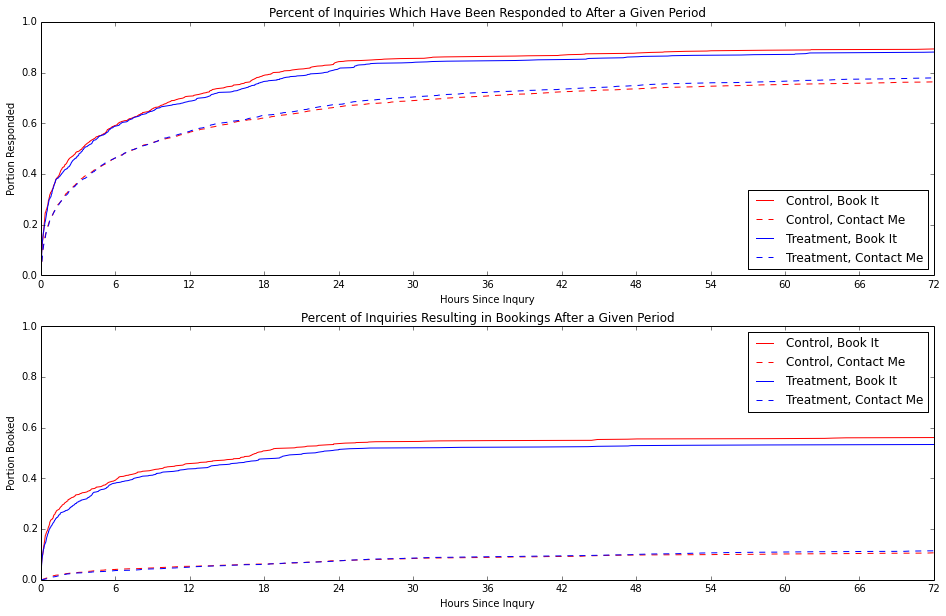

In [32]:
# Initalize the plots
f,subplts = plt.subplots(2,1)
f.set_size_inches(16,10)
hours = 72

# Initalize some arrays for plot
lincol = ['r','b']  # the line colors I'll use
linsty = ['-','--'] # line styles I'll use
loc    = ['lower right','upper right'] # where to put the legend
labels = np.array([['Control, Book It','Control, Contact Me'],['Treatment, Book It','Treatment, Contact Me']])

# Loop to add plots
for i in [0,1]:
    if i==0:
        subplts[0].set_title('Percent of Inquiries Which Have Been Responded to After a Given Period')
        subplts[0].set_ylabel('Portion Responded')
        var = data.ts_reply_at_first_lag
    else:
        subplts[1].set_title('Percent of Inquiries Resulting in Bookings After a Given Period')
        subplts[1].set_ylabel('Portion Booked')
        var = data.ts_booking_at_lag
    subplts[i].set_xlabel('Hours Since Inqury')
    subplts[i].set_ylim(0,1)
    subplts[i].set_xlim(0,60*60*hours)
    subplts[i].set_xticks(np.arange(0,hours+1,6)*60*60)
    subplts[i].set_xticklabels(np.arange(0,hours+1,6))
    # Loop over treatments
    for t in [0,1]:
        trt = ['control','treatment'][t]
        # Loop over booking criteria
        for b in [0,1]:
            book = ['book_it','contact_me'][b]
            subset = np.logical_and(data.ab==trt,data.dim_contact_channel==book) # those in the right treatment/booking group
            cond   = np.logical_and(pd.notnull(var),subset)                      # booked/replied in the right treatment/booking group
            count  = sum(cond)
            y      = np.linspace(0,count/sum(subset),count)
            subplts[i].plot(var.loc[cond].sort(inplace=False).astype('timedelta64[s]'),y,lincol[t]+linsty[b],label = labels[t,b])
    subplts[i].legend(loc=loc[i])

plt.show()

If there is any meaningful effect, it looks like "book it" requests are more successful in the control group. At first glance though, the difference between treatment and control is small at best.

### Fit a few regressions
There are a bunch of sexier models one might fit here, but this looks like a pretty cut and dry case, so I'm just going to fit a few old fashioned GLMs. This already is kind of overkill with this dataset.

##### Logits predicting reply or booking

I throw a bunch of polynomial terms to deal with the time of day the request was made and time of the year the request was made. For both of these, going to five degrees is likely gratuitous, but I'm not that interested in those effect and have plenty of data to spare a few degrees of freedom on. 

In [33]:
# Orthogoanl Polynomial for the minute of day. 
timeofday_poly, hour_norm, hour_alpha = \
    ortho_poly_fit(data.ts_interaction_first.dt.hour*60 + data.ts_interaction_first.dt.minute, degree=5)

# Polynomial for day of year contact was made
dayofyear_poly, day_norm, day_alpha = ortho_poly_fit(data.ts_interaction_first.dt.dayofyear, degree=5)

In [34]:
# fit a logit on a response
response_logit = smf.glm(formula="replied ~ ab*dim_contact_channel + timeofday_poly + weekend_interaction + dayofyear_poly", data=data, family=sm.families.Binomial()).fit()
response_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                          
===============================================================================================
Dep. Variable:     ['replied[False]', 'replied[True]']   No. Observations:                 9233
Model:                                             GLM   Df Residuals:                     9218
Model Family:                                 Binomial   Df Model:                           14
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:                -3730.2
Date:                                 Wed, 01 Jul 2015   Deviance:                       7460.4
Time:                                         09:07:30   Pearson chi2:                 9.21e+03
No. Iterations:                                      7                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -2.2673      0.129    -17.550      0.000        -2.520    -2.014
ab[T.treatment]                                       0.0931      0.175      0.531      0.596        -0.251     0.437
dim_contact_channel[T.contact_me]                     0.7160      0.127      5.622      0.000         0.466     0.966
weekend_interaction[T.True]                          -0.1634      0.068     -2.389      0.017        -0.298    -0.029
ab[T.treatment]:dim_contact_channel[T.contact_me]    -0.1867      0.187     -1.000      0.317        -0.553     0.179
timeofday_poly[0]                                    -0.0236      0.001    -17.550      0.000        -0.026    -0.021
timeofday_poly[1]                                    -5.5307      2.838     -1.949      0.051       -11.094     0.033
timeofday_poly[2]                                     4.9215      2.898      1.699      0.089        -0.758    10.601
timeofday_poly[3]                                     1.1730      2.876      0.408      0.683        -4.464     6.810
timeofday_poly[4]                                    -4.8016      2.884     -1.665      0.096       -10.454     0.851
timeofday_poly[5]                                     0.9561      2.868      0.333      0.739        -4.666     6.578
dayofyear_poly[0]                                    -0.0236      0.001    -17.550      0.000        -0.026    -0.021
dayofyear_poly[1]                                    -6.2970      3.140     -2.006      0.045       -12.451    -0.143
dayofyear_poly[2]                                   -18.1659      3.043     -5.969      0.000       -24.131   -12.201
dayofyear_poly[3]                                     7.0050      3.022      2.318      0.020         1.081    12.928
dayofyear_poly[4]                                     7.5630      3.014      2.509      0.012         1.656    13.470
dayofyear_poly[5]                                     1.3697      3.024      0.453      0.651        -4.556     7.296
=====================================================================================================================
"""

Neither the treatment nor treatment/contact channel interaction is signficant.

In [36]:
# fit a logit on a booking
response_logit = smf.glm(formula="booked ~ ab*dim_contact_channel + timeofday_poly + weekend_interaction + dayofyear_poly", data=data, family=sm.families.Binomial()).fit()
response_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Generalized Linear Model Regression Results                         
=============================================================================================
Dep. Variable:     ['booked[False]', 'booked[True]']   No. Observations:                 9233
Model:                                           GLM   Df Residuals:                     9218
Model Family:                               Binomial   Df Model:                           14
Link Function:                                 logit   Scale:                             1.0
Method:                                         IRLS   Log-Likelihood:                -4126.1
Date:                               Wed, 01 Jul 2015   Deviance:                       8252.2
Time:                                       09:08:38   Pearson chi2:                 9.25e+03
No. Iterations:                                    7                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.2762      0.083     -3.330      0.001        -0.439    -0.114
ab[T.treatment]                                       0.1044      0.100      1.045      0.296        -0.091     0.300
dim_contact_channel[T.contact_me]                     2.1922      0.082     26.607      0.000         2.031     2.354
weekend_interaction[T.True]                          -0.0323      0.065     -0.494      0.622        -0.160     0.096
ab[T.treatment]:dim_contact_channel[T.contact_me]    -0.1647      0.121     -1.367      0.172        -0.401     0.072
timeofday_poly[0]                                    -0.0029      0.001     -3.330      0.001        -0.005    -0.001
timeofday_poly[1]                                    -3.8737      2.700     -1.435      0.151        -9.166     1.419
timeofday_poly[2]                                     5.0489      2.701      1.869      0.062        -0.246    10.343
timeofday_poly[3]                                     2.0711      2.689      0.770      0.441        -3.199     7.341
timeofday_poly[4]                                    -0.8987      2.693     -0.334      0.739        -6.177     4.380
timeofday_poly[5]                                     2.4364      2.699      0.903      0.367        -2.854     7.727
dayofyear_poly[0]                                    -0.0029      0.001     -3.330      0.001        -0.005    -0.001
dayofyear_poly[1]                                     3.0181      2.661      1.134      0.257        -2.198     8.234
dayofyear_poly[2]                                    -8.2208      2.652     -3.100      0.002       -13.418    -3.023
dayofyear_poly[3]                                     0.4402      2.652      0.166      0.868        -4.758     5.639
dayofyear_poly[4]                                     2.9541      2.652      1.114      0.265        -2.244     8.152
dayofyear_poly[5]                                     0.6068      2.649      0.229      0.819        -4.585     5.798
=====================================================================================================================
"""

Both of these models say the same thing; neither for contact_me or book it does requiring a 140 word message result in a meaningful change in response or booking reates. There is plenty of room for improoved model selection, such as by interacting coefficients, but its pretty unlikely that main result will change.

##### Linear model predicting log time to response or booking
Just to beat on this dead horse a little more, lets see if the guests that get a response or booking do so quicker under the treatment.

In [37]:
# generate the outcome
# add some time to ensure no missing values after taking the log
logreply = np.log(data.ts_reply_at_first_lag.astype('timedelta64[s]')+120) 

# fit a logit on a response
response_logit = smf.ols(formula="logreply ~ ab*dim_contact_channel + timeofday_poly + weekend_interaction + dayofyear_poly",missing='drop',data=data).fit()
response_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logreply   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     33.42
Date:                Wed, 01 Jul 2015   Prob (F-statistic):           3.20e-88
Time:                        09:09:12   Log-Likelihood:                -17513.
No. Observations:                7910   AIC:                         3.506e+04
Df Residuals:                    7895   BIC:                         3.516e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             9.1091      0.089    102.888      0.000         8.936     9.283
ab[T.treatment]                                       0.1112      0.115      0.968      0.333        -0.114     0.336
dim_contact_channel[T.contact_me]                     0.5994      0.086      6.956      0.000         0.430     0.768
weekend_interaction[T.True]                          -0.2680      0.059     -4.556      0.000        -0.383    -0.153
ab[T.treatment]:dim_contact_channel[T.contact_me]    -0.0855      0.128     -0.670      0.503        -0.336     0.165
timeofday_poly[0]                                     0.0948      0.001    102.888      0.000         0.093     0.097
timeofday_poly[1]                                   -16.0989      2.404     -6.695      0.000       -20.812   -11.385
timeofday_poly[2]                                   -18.5821      2.396     -7.756      0.000       -23.278   -13.886
timeofday_poly[3]                                    18.2011      2.402      7.579      0.000        13.493    22.909
timeofday_poly[4]                                    16.1274      2.392      6.741      0.000        11.438    20.817
timeofday_poly[5]                                   -13.0939      2.396     -5.465      0.000       -17.791    -8.397
dayofyear_poly[0]                                     0.0948      0.001    102.888      0.000         0.093     0.097
dayofyear_poly[1]                                   -18.3957      2.387     -7.706      0.000       -23.075   -13.716
dayofyear_poly[2]                                   -11.1289      2.382     -4.672      0.000       -15.798    -6.460
dayofyear_poly[3]                                     7.7496      2.387      3.246      0.001         3.070    12.429
dayofyear_poly[4]                                    -0.5309      2.375     -0.224      0.823        -5.187     4.125
dayofyear_poly[5]                                    -0.0276      2.375     -0.012      0.991        -4.682     4.627
==============================================================================
Omnibus:                        9.271   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.413
Skew:                           0.037   Prob(JB):                       0.0149
Kurtosis:                       2.858   Cond. No.                     2.23e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.4e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular

Again, neither the treatment nor treatment/contact channel interaction is signficant.

In [38]:
# generate the outcome, this time booking lag
logreply = np.log(data.ts_booking_at_lag.astype('timedelta64[s]')+120) # need to ensure there are no negative values

# fit a logit on a response
response_logit = smf.ols(formula="logreply ~ ab*dim_contact_channel + timeofday_poly + weekend_interaction + dayofyear_poly",missing='drop',data=data).fit()
response_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logreply   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     51.40
Date:                Wed, 01 Jul 2015   Prob (F-statistic):          6.54e-122
Time:                        09:09:49   Log-Likelihood:                -4118.8
No. Observations:                1951   AIC:                             8268.
Df Residuals:                    1936   BIC:                             8351.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             8.7405      0.120     72.977      0.000         8.506     8.975
ab[T.treatment]                                       0.1085      0.133      0.815      0.415        -0.153     0.370
dim_contact_channel[T.contact_me]                     2.2841      0.124     18.355      0.000         2.040     2.528
weekend_interaction[T.True]                          -0.2262      0.107     -2.119      0.034        -0.435    -0.017
ab[T.treatment]:dim_contact_channel[T.contact_me]     0.0081      0.183      0.044      0.965        -0.351     0.367
timeofday_poly[0]                                     0.0910      0.001     72.977      0.000         0.089     0.093
timeofday_poly[1]                                   -16.3962      4.422     -3.708      0.000       -25.068    -7.725
timeofday_poly[2]                                   -17.5669      4.444     -3.953      0.000       -26.283    -8.851
timeofday_poly[3]                                     8.8165      4.465      1.975      0.048         0.060    17.574
timeofday_poly[4]                                    17.5891      4.419      3.981      0.000         8.923    26.255
timeofday_poly[5]                                    -8.8845      4.504     -1.973      0.049       -17.718    -0.051
dayofyear_poly[0]                                     0.0910      0.001     72.977      0.000         0.089     0.093
dayofyear_poly[1]                                    -5.3904      4.293     -1.256      0.209       -13.809     3.028
dayofyear_poly[2]                                    -1.5911      4.320     -0.368      0.713       -10.064     6.882
dayofyear_poly[3]                                     6.5022      4.301      1.512      0.131        -1.933    14.938
dayofyear_poly[4]                                    -2.5591      4.284     -0.597      0.550       -10.960     5.842
dayofyear_poly[5]                                    -0.9927      4.324     -0.230      0.818        -9.473     7.487
==============================================================================
Omnibus:                       19.438   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.848
Skew:                          -0.247   Prob(JB):                     4.90e-05
Kurtosis:                       3.005   Cond. No.                     3.69e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.27e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singula

Again, the treatment doesn't make a statistically signficant difference. Time of day when the request is sent is much more important though, as one might expect.